In [1]:
import itertools
import os
from deepface import DeepFace
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(" GPU trouvé:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU non trouvé, le processeur sera utilisé.")

 GPU trouvé: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def run_model(detector_backend, dataset):
    expand_percentages = [0, 10, 20]
    align_options = [True, False]
    all_results = []
    
    if dataset == "facial_emotion_detection_dataset":
        dataset_path = "../datasets/facial_emotion_detection_dataset_cropped"
        emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        save_directory = "informations_facial_emotion_detection_dataset/" + detector_backend
    elif dataset == "CK+":
        dataset_path = "../datasets/CK+48"
        emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']
        save_directory = "informations_ck_plus/" + detector_backend

    print(f"\n \033[1m{detector_backend} - {dataset}\033[0m")
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))  
    axes = axes.flatten() 
    
    for idx, (expand, align) in enumerate(itertools.product(expand_percentages, align_options)):
        print(f"\n--- Test: expand_percentage={expand}, align={align} ---")
        start_time = time.time()

        true_labels = []
        pred_labels = []
        confidences = []
        detected_images = []
    
        for emotion in emotion_labels:
            emotion_folder = os.path.join(dataset_path, emotion)
            if not os.path.isdir(emotion_folder):
                continue
            for img_file in os.listdir(emotion_folder):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(emotion_folder, img_file)
                    result = DeepFace.analyze(
                        img_path=img_path,
                        actions=['emotion'],
                        enforce_detection=False,
                        detector_backend=detector_backend,
                        align=align,
                        expand_percentage=expand,
                        silent=True
                    )
                    if not result:
                        continue
                    predicted = result[0]['dominant_emotion']
                    if dataset=="CK+"  and predicted=="neutral":
                        result[0]['emotion'].pop("neutral")
                        predicted = max(result[0]['emotion'], key=result[0]['emotion'].get)

                    emotion_result = result[0]['emotion']
                    confidence = emotion_result.get(predicted, 0.0)

                    true_labels.append(emotion)
                    pred_labels.append(predicted)
                    confidences.append(confidence)
                    detected_images.append(img_path)

    
        if not true_labels:
            print("No predictions for this config, skipping confusion matrix.")
            continue
    
        acc = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
        avg_conf = np.mean(confidences)
        end_time = time.time()
        elapsed_time = end_time - start_time
        all_results.append(((expand, align), acc, f1, avg_conf, elapsed_time))
        
        elapsed_hours, elapsed_minutes, elapsed_seconds= int(elapsed_time // 3600), int((elapsed_time % 3600) // 60), int(elapsed_time % 60)

        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Avg Confidence: {avg_conf:.2f} | Elapsed Time: {elapsed_hours}h {elapsed_minutes}m {elapsed_seconds}s")
    
        used_labels = sorted(set(true_labels + pred_labels))
        cm = confusion_matrix(true_labels, pred_labels, labels=used_labels)
        
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=used_labels, yticklabels=used_labels, ax=ax)
        ax.set_title(f"expand={expand}, align={align}")
        ax.set_xlabel("Classe Estimée")
        ax.set_ylabel("Classe Réelle")

    
    fig.suptitle(f"{detector_backend} - {dataset} - Confusion Matrices", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = f"{detector_backend}_confusion_matrices.png"
    filepath = os.path.join(save_directory, filename)
    os.makedirs(save_directory, exist_ok=True)
    
    fig.savefig(filepath)
    fig.set_dpi(60)
    plt.show()
    plt.close()
        
    results_txt_path = os.path.join(save_directory, f"{detector_backend}_results_summary.txt")
    
    with open(results_txt_path, "w", encoding="utf-8") as f:
        for (expand, align), acc, f1, conf, elapsed in all_results:
            elapsed_hours = int(elapsed // 3600)
            elapsed_minutes = int((elapsed % 3600) // 60)
            elapsed_seconds = int(elapsed % 60)
            f.write(f"--- Test: expand_percentage={expand}, align={align} ---\n")
            f.write(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Avg Confidence: {conf:.2f}\n\n")
            f.write(f"Elapsed Time: {elapsed_hours}h {elapsed_minutes}m {elapsed_seconds}s\n\n")

    
    print(f"\n Résultats enregistrés dans {results_txt_path}")


**Detector Backend Options:**

- `opencv`
- `ssd`
- `dlib`
- `mtcnn`
- `fastmtcnn`
- `retinaface`
- `yolov8`
- `yunet`
- `centerface`

<br>

**Dataset Options:**

- `facial_emotion_detection_dataset`
- `CK+`


# **Detector Backend : opencv**


 opencv - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6003 | F1: 0.3492 | Avg Confidence: 81.63 | Elapsed Time: 0h 0m 13s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6554 | F1: 0.4124 | Avg Confidence: 83.50 | Elapsed Time: 0h 0m 7s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5480 | F1: 0.2998 | Avg Confidence: 79.00 | Elapsed Time: 0h 0m 10s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6511 | F1: 0.4044 | Avg Confidence: 83.64 | Elapsed Time: 0h 0m 7s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4972 | F1: 0.2795 | Avg Confidence: 76.97 | Elapsed Time: 0h 0m 10s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6469 | F1: 0.3986 | Avg Confidence: 83.83 | Elapsed Time: 0h 0m 7s


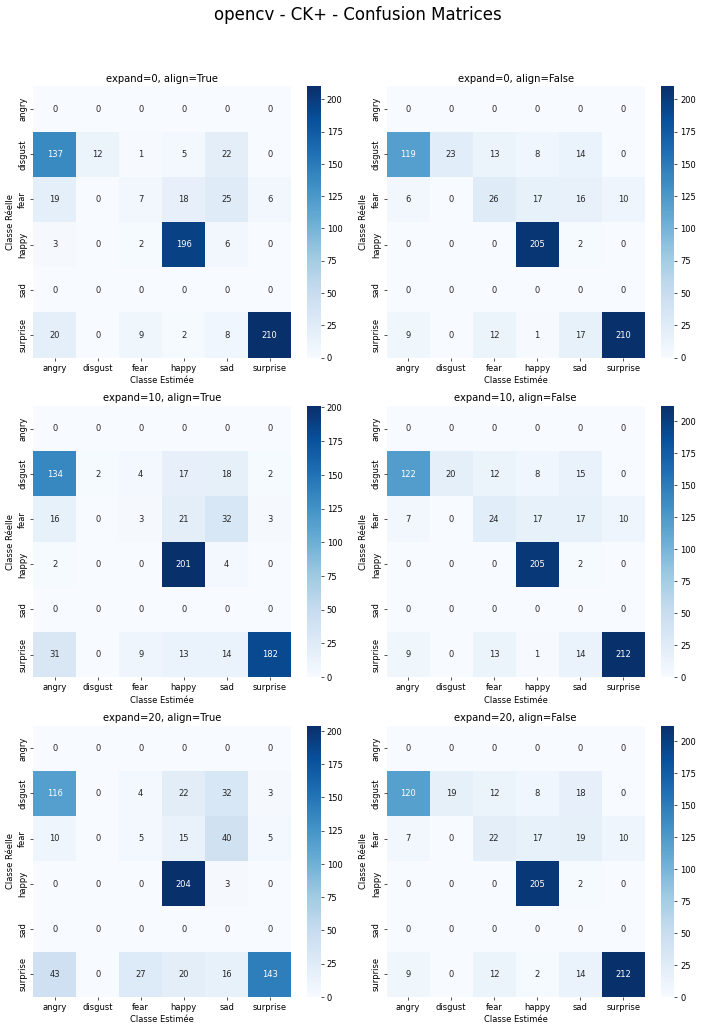


 Résultats enregistrés dans informations_ck_plus/opencv\opencv_results_summary.txt


In [4]:
run_model("opencv", "CK+")


 opencv - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5124 | F1: 0.4694 | Avg Confidence: 80.76 | Elapsed Time: 0h 1m 36s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5047 | F1: 0.4679 | Avg Confidence: 81.90 | Elapsed Time: 0h 1m 6s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4670 | F1: 0.4271 | Avg Confidence: 81.12 | Elapsed Time: 0h 1m 30s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5045 | F1: 0.4676 | Avg Confidence: 81.90 | Elapsed Time: 0h 1m 7s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4334 | F1: 0.3906 | Avg Confidence: 81.00 | Elapsed Time: 0h 1m 32s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5046 | F1: 0.4678 | Avg Confidence: 81.91 | Elapsed Time: 0h 1m 2s


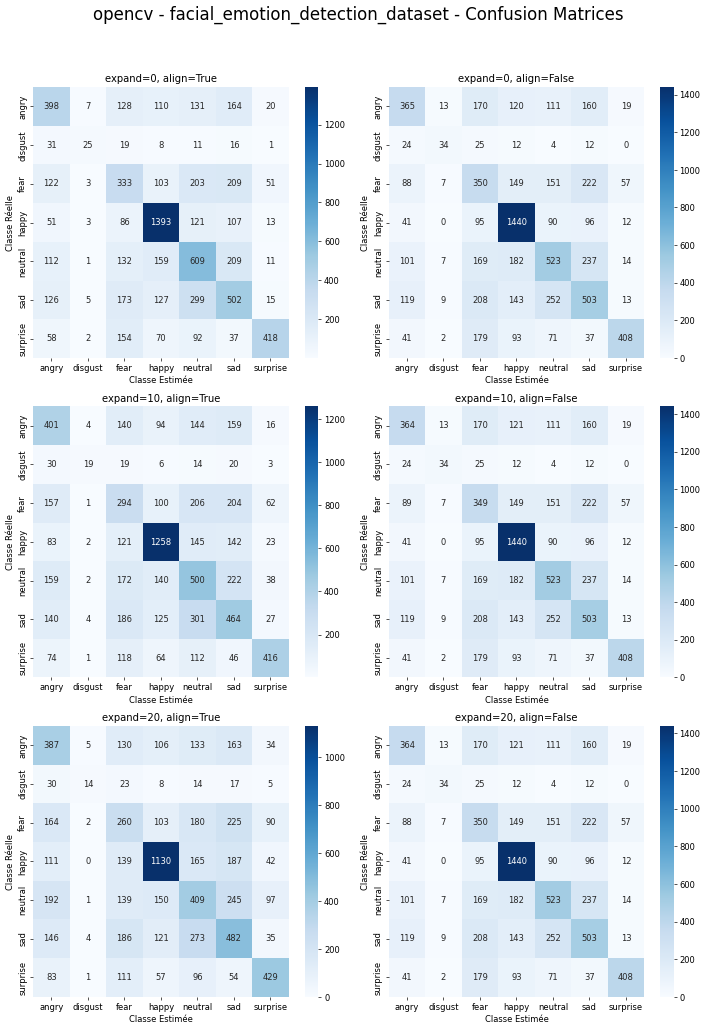


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/opencv\opencv_results_summary.txt


In [5]:
run_model("opencv", "facial_emotion_detection_dataset")

# **Detector Backend : ssd**


 ssd - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6356 | F1: 0.3768 | Avg Confidence: 81.80 | Elapsed Time: 0h 0m 24s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.1667 | F1: 0.1459 | Avg Confidence: 83.58 | Elapsed Time: 0h 0m 24s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.6144 | F1: 0.3642 | Avg Confidence: 82.21 | Elapsed Time: 0h 0m 24s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.2034 | F1: 0.1665 | Avg Confidence: 84.14 | Elapsed Time: 0h 0m 25s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5353 | F1: 0.3081 | Avg Confidence: 79.61 | Elapsed Time: 0h 0m 25s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.2881 | F1: 0.2115 | Avg Confidence: 86.33 | Elapsed Time: 0h 0m 25s


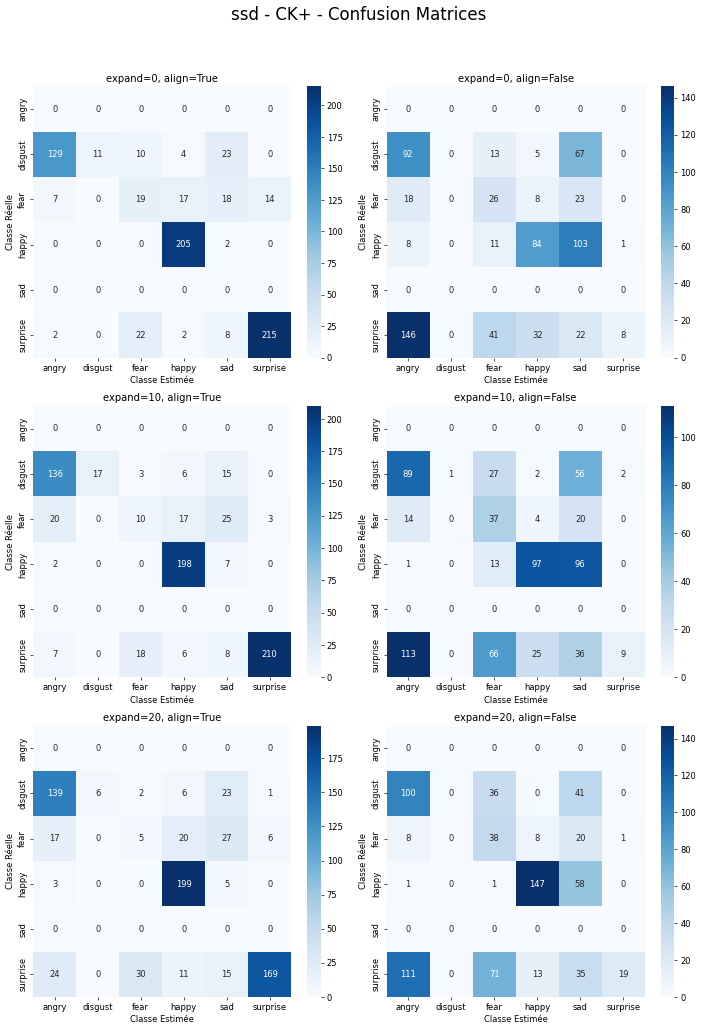


 Résultats enregistrés dans informations_ck_plus/ssd\ssd_results_summary.txt


In [6]:
run_model("ssd", "CK+")


 ssd - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.4781 | F1: 0.4263 | Avg Confidence: 80.81 | Elapsed Time: 0h 4m 20s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.1985 | F1: 0.1553 | Avg Confidence: 82.01 | Elapsed Time: 0h 4m 21s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4733 | F1: 0.4164 | Avg Confidence: 81.17 | Elapsed Time: 0h 4m 26s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.2081 | F1: 0.1608 | Avg Confidence: 81.87 | Elapsed Time: 0h 4m 20s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4572 | F1: 0.3935 | Avg Confidence: 81.00 | Elapsed Time: 0h 4m 25s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.2348 | F1: 0.1909 | Avg Confidence: 81.22 | Elapsed Time: 0h 4m 19s


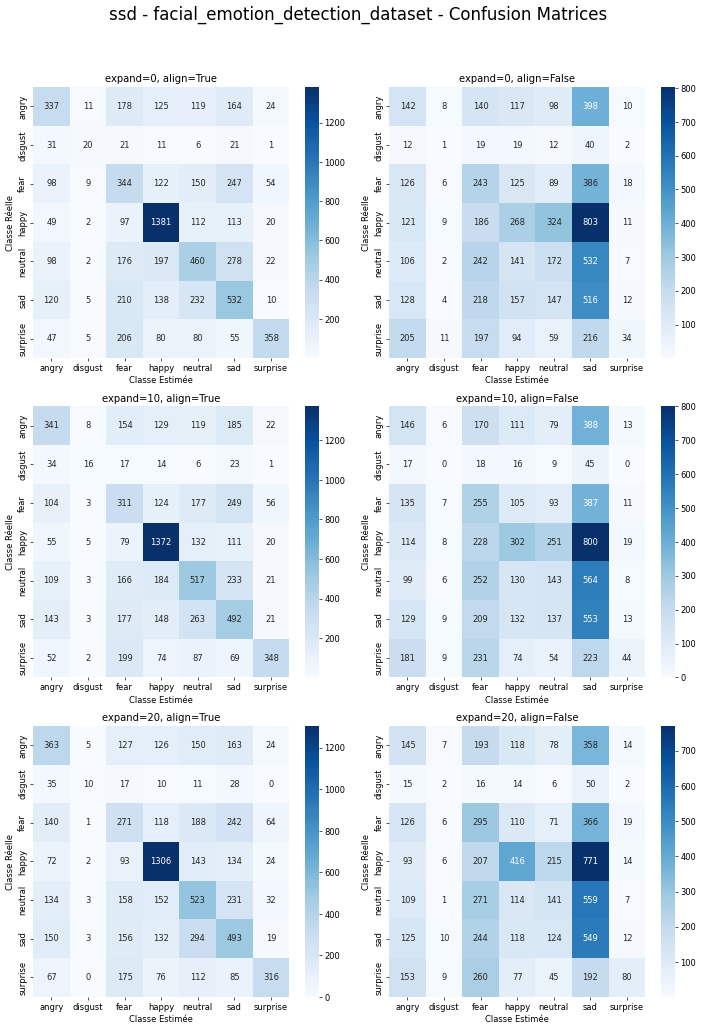


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/ssd\ssd_results_summary.txt


In [7]:
run_model("ssd", "facial_emotion_detection_dataset")

# **Detector Backend : dlib**


 dlib - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6469 | F1: 0.4117 | Avg Confidence: 77.43 | Elapsed Time: 0h 0m 12s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6427 | F1: 0.4084 | Avg Confidence: 80.44 | Elapsed Time: 0h 0m 7s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.6441 | F1: 0.4067 | Avg Confidence: 77.43 | Elapsed Time: 0h 0m 12s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6412 | F1: 0.4016 | Avg Confidence: 81.52 | Elapsed Time: 0h 0m 7s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.6102 | F1: 0.3598 | Avg Confidence: 82.43 | Elapsed Time: 0h 0m 11s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6596 | F1: 0.4039 | Avg Confidence: 82.55 | Elapsed Time: 0h 0m 7s


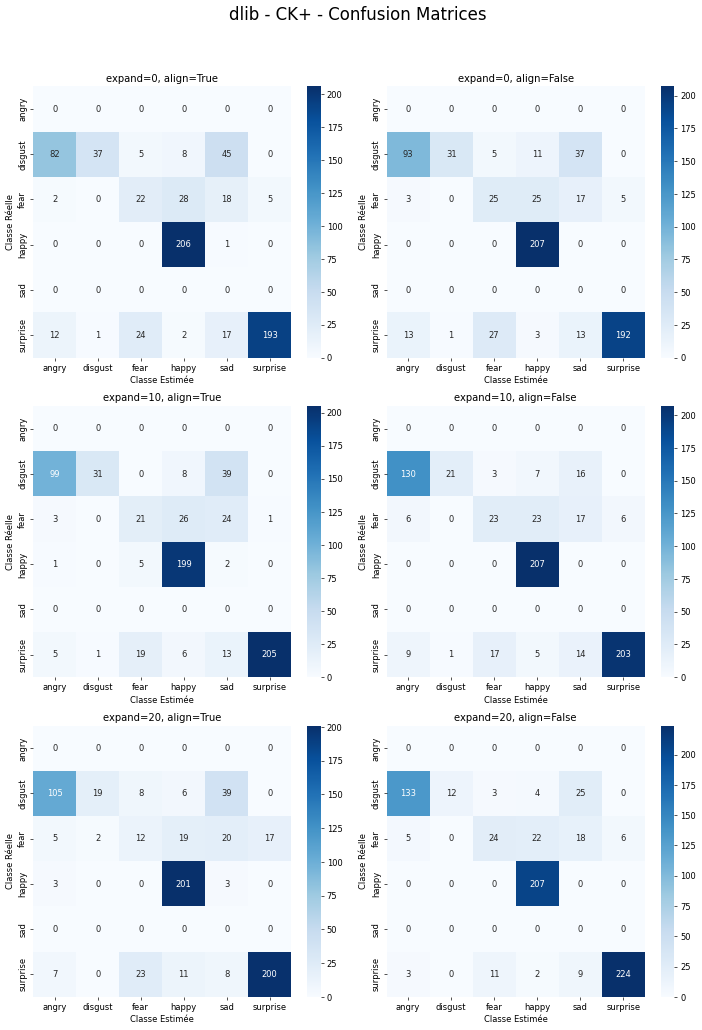


 Résultats enregistrés dans informations_ck_plus/dlib\dlib_results_summary.txt


In [8]:
run_model("dlib", "CK+")


 dlib - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.4706 | F1: 0.4225 | Avg Confidence: 80.79 | Elapsed Time: 0h 1m 54s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.4898 | F1: 0.4467 | Avg Confidence: 81.36 | Elapsed Time: 0h 1m 11s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4735 | F1: 0.4252 | Avg Confidence: 81.08 | Elapsed Time: 0h 1m 54s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.4980 | F1: 0.4560 | Avg Confidence: 81.41 | Elapsed Time: 0h 1m 13s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4684 | F1: 0.4190 | Avg Confidence: 81.12 | Elapsed Time: 0h 1m 54s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5025 | F1: 0.4596 | Avg Confidence: 81.71 | Elapsed Time: 0h 1m 12s


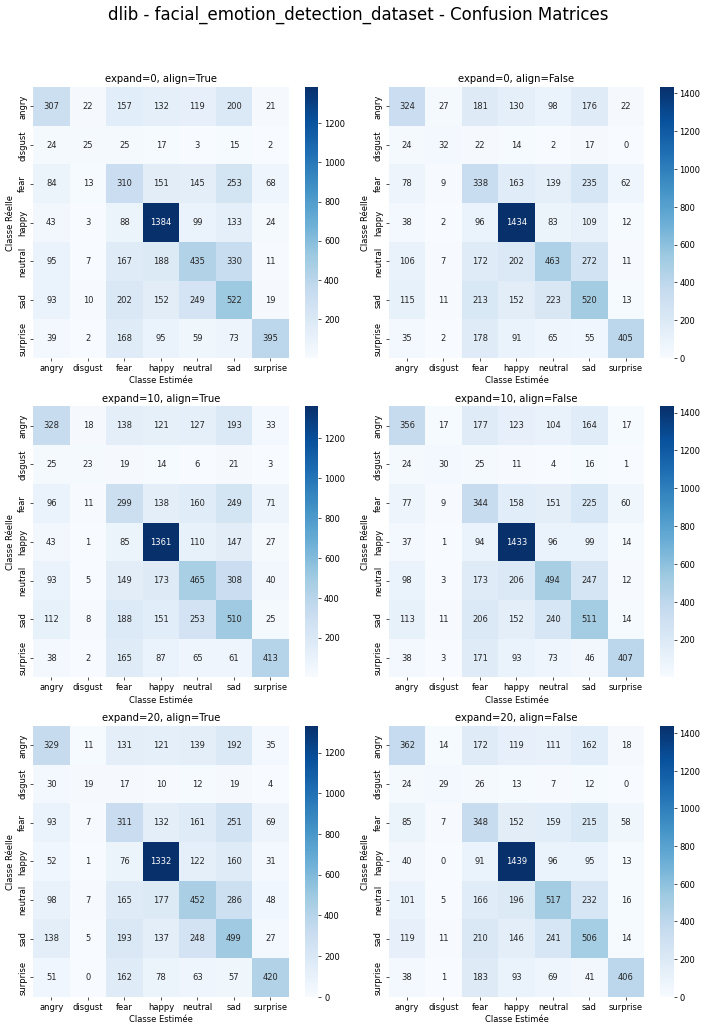


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/dlib\dlib_results_summary.txt


In [9]:
run_model("dlib", "facial_emotion_detection_dataset")

# **Detector Backend : retinaface**


 retinaface - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6031 | F1: 0.3573 | Avg Confidence: 79.71 | Elapsed Time: 0h 2m 4s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6285 | F1: 0.3893 | Avg Confidence: 82.84 | Elapsed Time: 0h 1m 59s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5537 | F1: 0.3320 | Avg Confidence: 78.77 | Elapsed Time: 0h 1m 57s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6257 | F1: 0.3889 | Avg Confidence: 82.92 | Elapsed Time: 0h 1m 58s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4661 | F1: 0.2762 | Avg Confidence: 74.96 | Elapsed Time: 0h 1m 57s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6342 | F1: 0.3958 | Avg Confidence: 82.78 | Elapsed Time: 0h 1m 58s


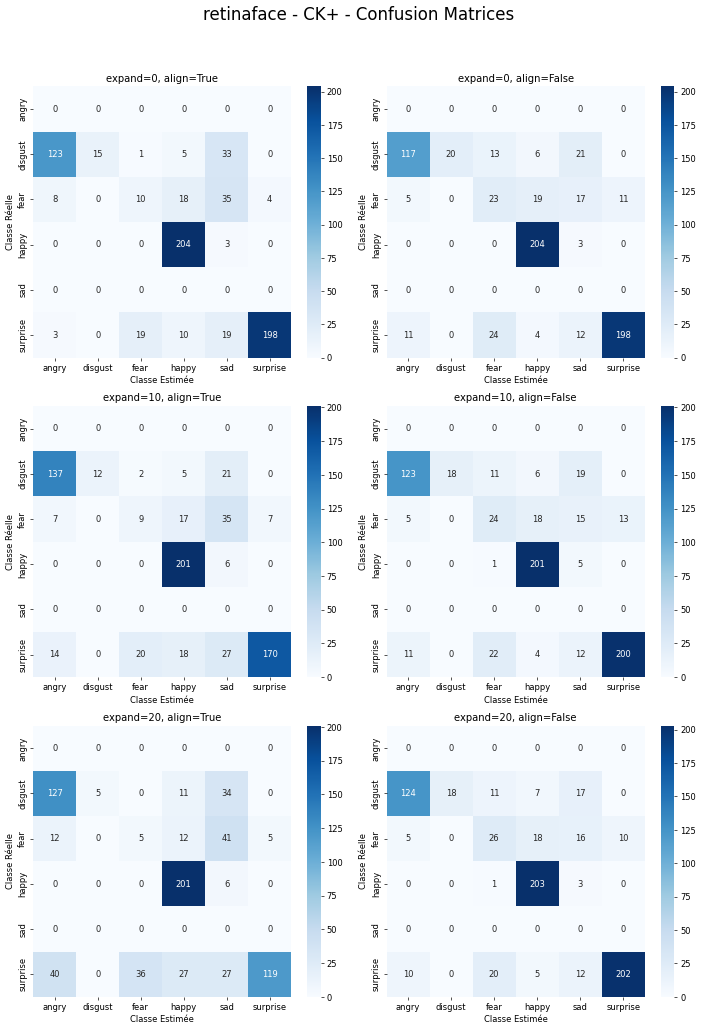


 Résultats enregistrés dans informations_ck_plus/retinaface\retinaface_results_summary.txt


In [10]:
run_model("retinaface", "CK+")


 retinaface - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.4615 | F1: 0.3834 | Avg Confidence: 81.56 | Elapsed Time: 0h 20m 22s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5025 | F1: 0.4659 | Avg Confidence: 81.90 | Elapsed Time: 0h 20m 5s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4283 | F1: 0.3523 | Avg Confidence: 81.50 | Elapsed Time: 0h 19m 57s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5031 | F1: 0.4661 | Avg Confidence: 81.92 | Elapsed Time: 0h 20m 5s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.3731 | F1: 0.3084 | Avg Confidence: 81.95 | Elapsed Time: 0h 20m 0s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5024 | F1: 0.4654 | Avg Confidence: 81.89 | Elapsed Time: 0h 20m 9s


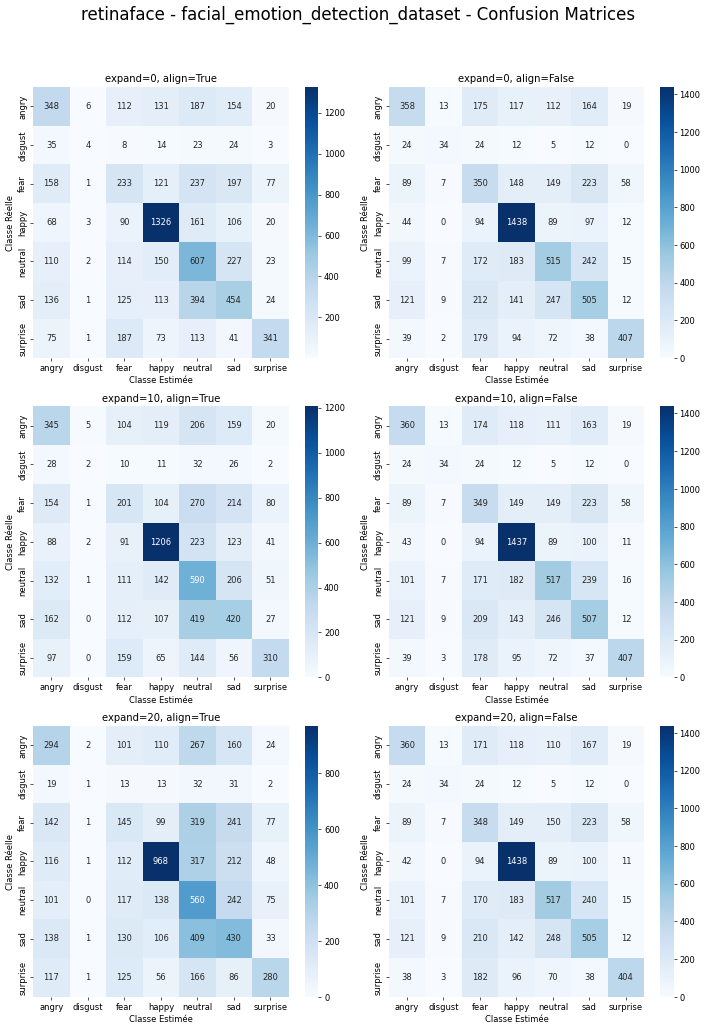


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/retinaface\retinaface_results_summary.txt


In [11]:
run_model("retinaface", "facial_emotion_detection_dataset")

# **Detector Backend : yolov8**


 yolov8 - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6427 | F1: 0.4012 | Avg Confidence: 80.79 | Elapsed Time: 0h 1m 15s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6215 | F1: 0.3747 | Avg Confidence: 81.60 | Elapsed Time: 0h 1m 9s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.6243 | F1: 0.3818 | Avg Confidence: 81.15 | Elapsed Time: 0h 1m 9s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6455 | F1: 0.3975 | Avg Confidence: 82.85 | Elapsed Time: 0h 1m 9s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5678 | F1: 0.3243 | Avg Confidence: 80.09 | Elapsed Time: 0h 1m 9s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6483 | F1: 0.4010 | Avg Confidence: 83.10 | Elapsed Time: 0h 1m 9s


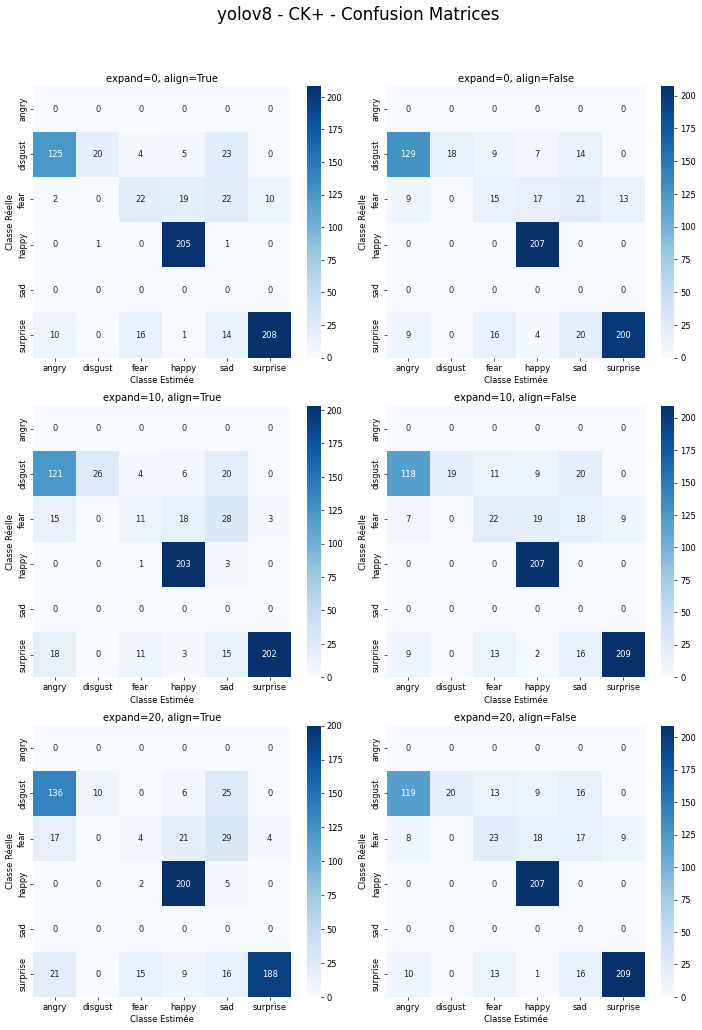


 Résultats enregistrés dans informations_ck_plus/yolov8\yolov8_results_summary.txt


In [12]:
run_model("yolov8", "CK+")


 yolov8 - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.4472 | F1: 0.3950 | Avg Confidence: 81.20 | Elapsed Time: 0h 11m 45s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.4433 | F1: 0.3986 | Avg Confidence: 80.81 | Elapsed Time: 0h 11m 50s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4480 | F1: 0.3839 | Avg Confidence: 81.53 | Elapsed Time: 0h 11m 47s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.4781 | F1: 0.4400 | Avg Confidence: 80.91 | Elapsed Time: 0h 11m 44s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4285 | F1: 0.3541 | Avg Confidence: 82.18 | Elapsed Time: 0h 11m 43s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.4983 | F1: 0.4619 | Avg Confidence: 81.18 | Elapsed Time: 0h 11m 39s


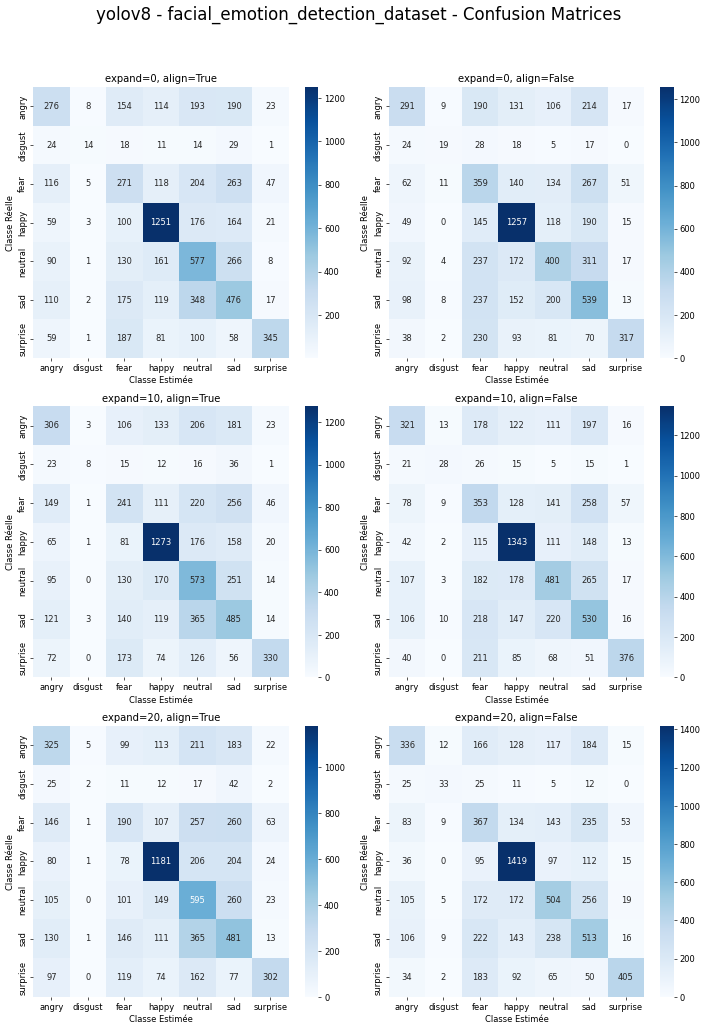


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/yolov8\yolov8_results_summary.txt


In [13]:
run_model("yolov8", "facial_emotion_detection_dataset")

# **Detector Backend : yunet**


 yunet - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6483 | F1: 0.3950 | Avg Confidence: 83.39 | Elapsed Time: 0h 0m 6s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6271 | F1: 0.3856 | Avg Confidence: 81.46 | Elapsed Time: 0h 0m 6s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.6299 | F1: 0.3797 | Avg Confidence: 83.89 | Elapsed Time: 0h 0m 6s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6271 | F1: 0.3826 | Avg Confidence: 83.48 | Elapsed Time: 0h 0m 6s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.6172 | F1: 0.3738 | Avg Confidence: 83.56 | Elapsed Time: 0h 0m 6s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6271 | F1: 0.3865 | Avg Confidence: 83.59 | Elapsed Time: 0h 0m 6s


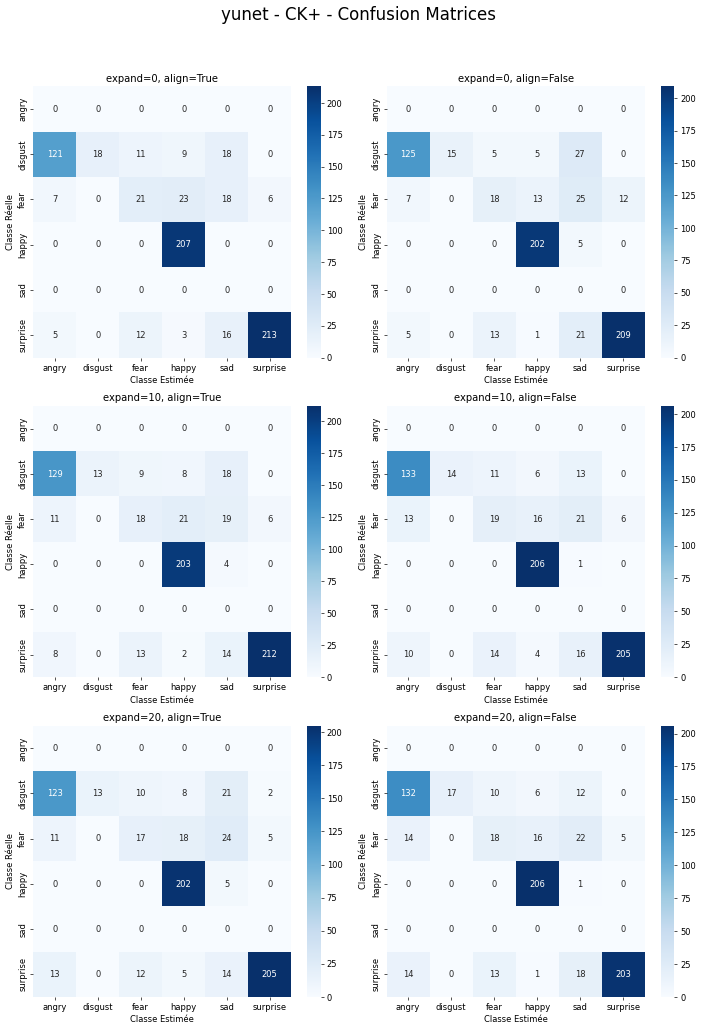


 Résultats enregistrés dans informations_ck_plus/yunet\yunet_results_summary.txt


In [14]:
run_model("yunet", "CK+")


 yunet - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5045 | F1: 0.4677 | Avg Confidence: 81.87 | Elapsed Time: 0h 1m 7s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5040 | F1: 0.4686 | Avg Confidence: 81.75 | Elapsed Time: 0h 1m 6s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5039 | F1: 0.4669 | Avg Confidence: 81.86 | Elapsed Time: 0h 1m 8s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5052 | F1: 0.4690 | Avg Confidence: 81.84 | Elapsed Time: 0h 1m 7s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5033 | F1: 0.4666 | Avg Confidence: 81.88 | Elapsed Time: 0h 1m 10s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5046 | F1: 0.4687 | Avg Confidence: 81.89 | Elapsed Time: 0h 1m 7s


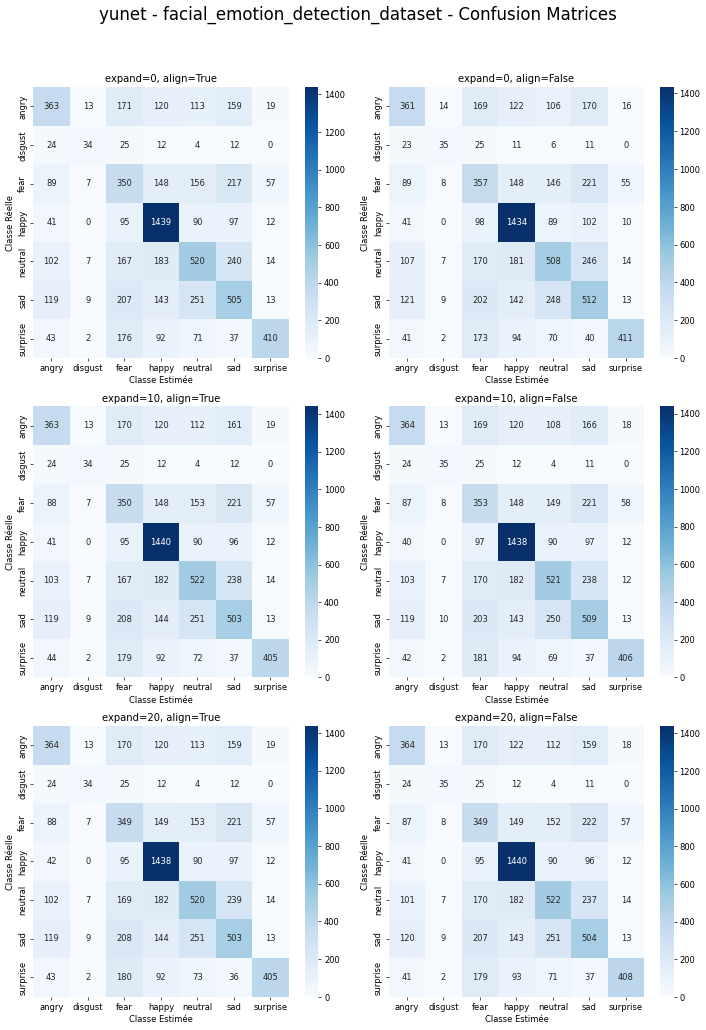


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/yunet\yunet_results_summary.txt


In [15]:
run_model("yunet", "facial_emotion_detection_dataset")

# **Detector Backend : centerface**


 centerface - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6483 | F1: 0.4001 | Avg Confidence: 83.85 | Elapsed Time: 0h 0m 45s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6596 | F1: 0.4121 | Avg Confidence: 83.96 | Elapsed Time: 0h 0m 44s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.6483 | F1: 0.4005 | Avg Confidence: 83.92 | Elapsed Time: 0h 0m 45s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6525 | F1: 0.4024 | Avg Confidence: 83.35 | Elapsed Time: 0h 0m 44s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.6483 | F1: 0.4005 | Avg Confidence: 83.98 | Elapsed Time: 0h 0m 46s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6497 | F1: 0.4009 | Avg Confidence: 83.86 | Elapsed Time: 0h 0m 44s


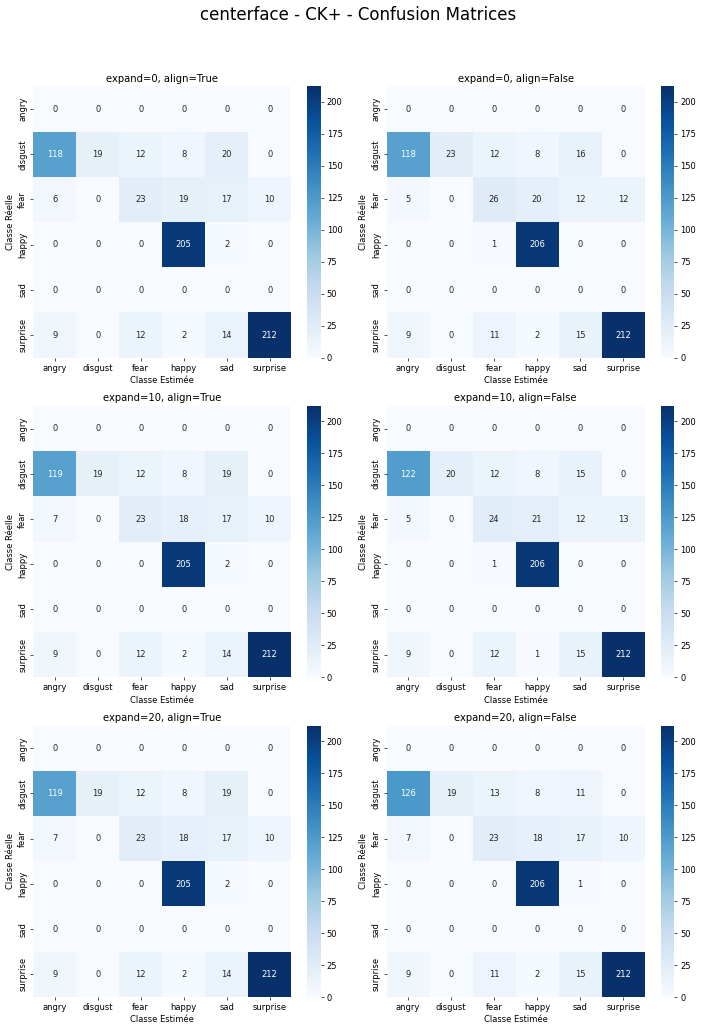


 Résultats enregistrés dans informations_ck_plus/centerface\centerface_results_summary.txt


In [16]:
run_model("centerface", "CK+")


 centerface - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.5045 | F1: 0.4662 | Avg Confidence: 81.86 | Elapsed Time: 0h 7m 39s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5004 | F1: 0.4650 | Avg Confidence: 81.77 | Elapsed Time: 0h 7m 29s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5035 | F1: 0.4655 | Avg Confidence: 81.92 | Elapsed Time: 0h 7m 38s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5036 | F1: 0.4673 | Avg Confidence: 81.75 | Elapsed Time: 0h 7m 31s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5018 | F1: 0.4641 | Avg Confidence: 81.92 | Elapsed Time: 0h 7m 39s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5043 | F1: 0.4676 | Avg Confidence: 81.87 | Elapsed Time: 0h 7m 28s


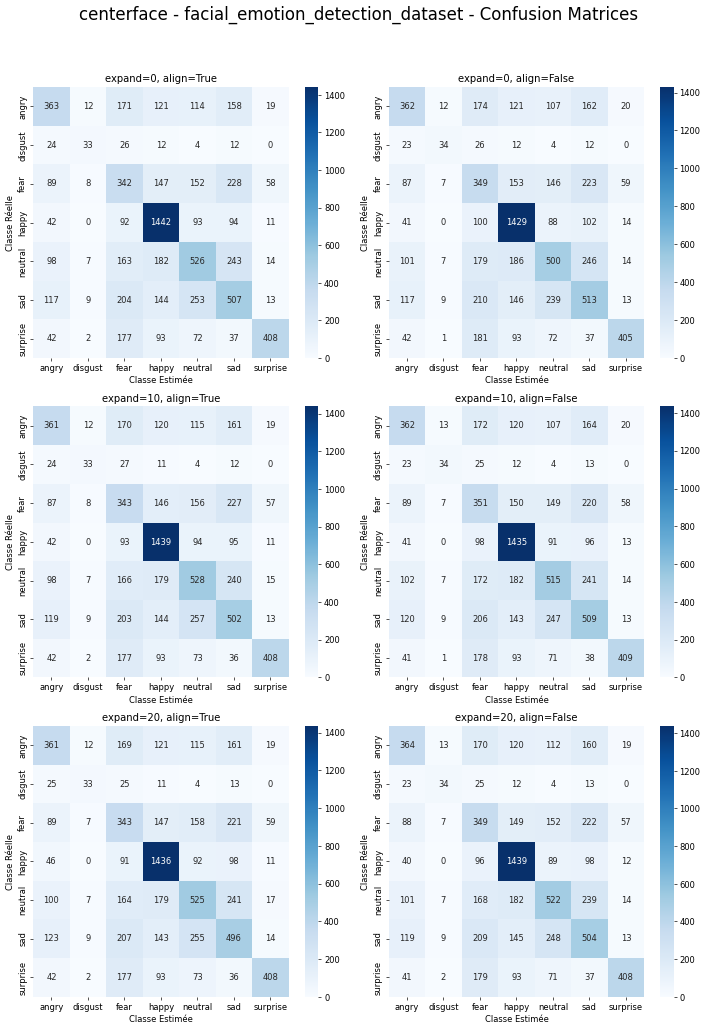


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/centerface\centerface_results_summary.txt


In [17]:
run_model("centerface", "facial_emotion_detection_dataset")

# **Detector Backend : fastmtcnn**


 fastmtcnn - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6073 | F1: 0.3682 | Avg Confidence: 78.86 | Elapsed Time: 0h 0m 21s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.5367 | F1: 0.3443 | Avg Confidence: 82.25 | Elapsed Time: 0h 0m 16s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5720 | F1: 0.3511 | Avg Confidence: 78.93 | Elapsed Time: 0h 0m 20s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6384 | F1: 0.3965 | Avg Confidence: 82.21 | Elapsed Time: 0h 0m 16s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4887 | F1: 0.2951 | Avg Confidence: 76.84 | Elapsed Time: 0h 0m 20s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6455 | F1: 0.3979 | Avg Confidence: 83.43 | Elapsed Time: 0h 0m 16s


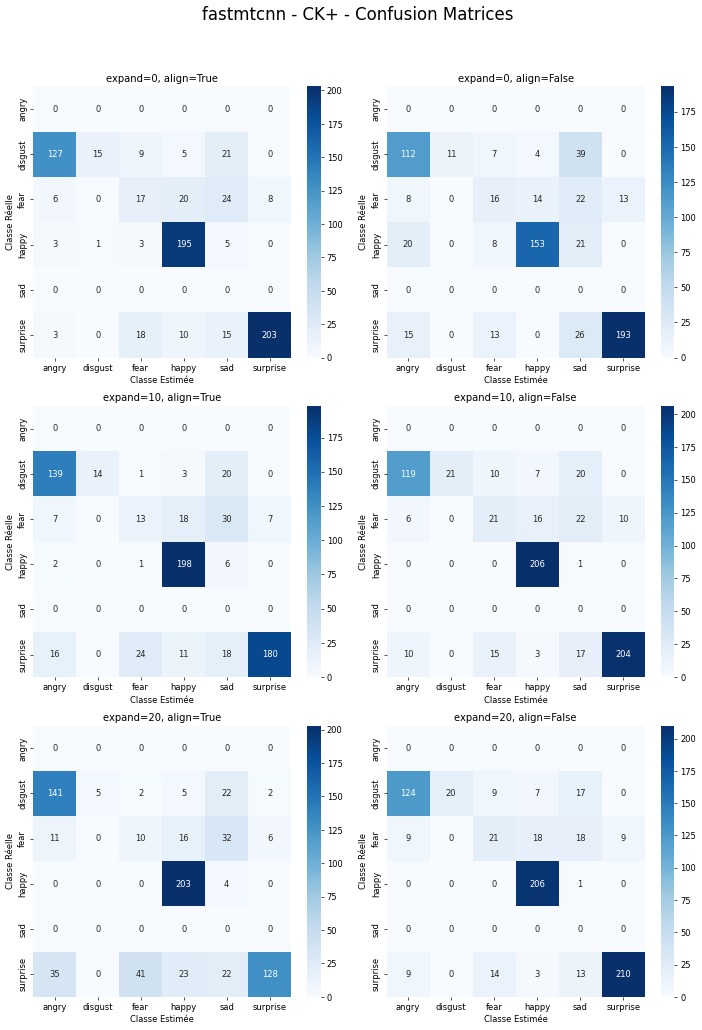


 Résultats enregistrés dans informations_ck_plus/fastmtcnn\fastmtcnn_results_summary.txt


In [18]:
run_model("fastmtcnn", "CK+")


 fastmtcnn - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.4929 | F1: 0.4419 | Avg Confidence: 80.55 | Elapsed Time: 0h 3m 5s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.2506 | F1: 0.2301 | Avg Confidence: 86.78 | Elapsed Time: 0h 2m 16s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4680 | F1: 0.4078 | Avg Confidence: 80.86 | Elapsed Time: 0h 3m 4s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.5047 | F1: 0.4673 | Avg Confidence: 81.86 | Elapsed Time: 0h 2m 23s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.4303 | F1: 0.3631 | Avg Confidence: 80.98 | Elapsed Time: 0h 3m 4s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.5056 | F1: 0.4677 | Avg Confidence: 81.87 | Elapsed Time: 0h 2m 22s


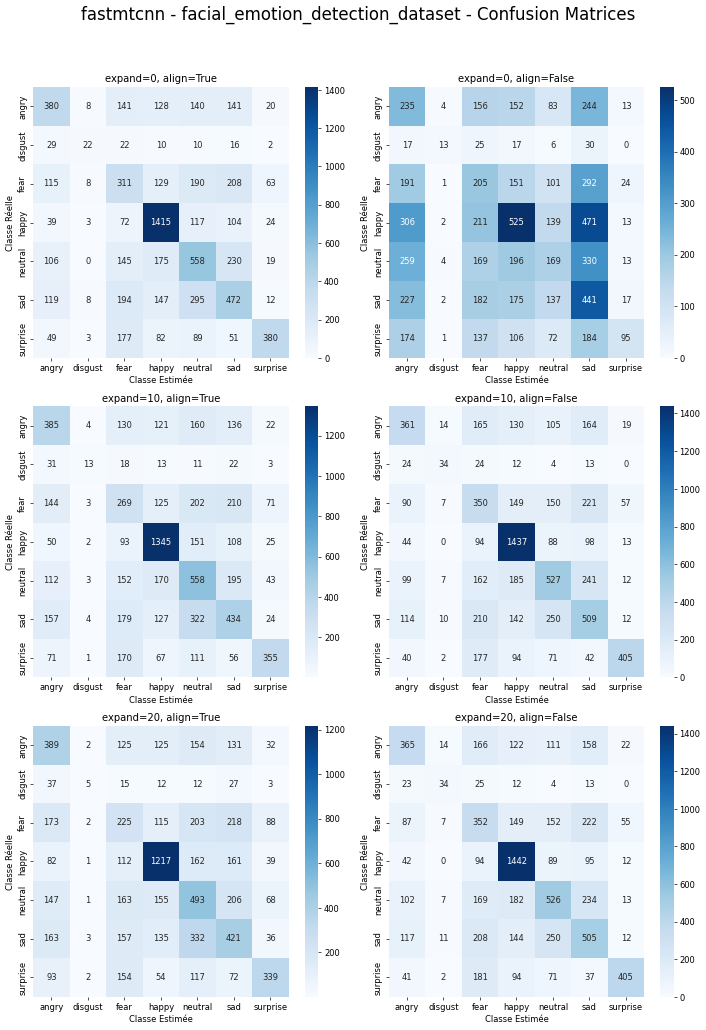


 Résultats enregistrés dans informations_facial_emotion_detection_dataset/fastmtcnn\fastmtcnn_results_summary.txt


In [19]:
run_model("fastmtcnn", "facial_emotion_detection_dataset")

# **Detector Backend : mtcnn**


 mtcnn - CK+

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.6130 | F1: 0.3642 | Avg Confidence: 79.99 | Elapsed Time: 0h 4m 44s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.6370 | F1: 0.3815 | Avg Confidence: 81.45 | Elapsed Time: 0h 3m 28s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.5650 | F1: 0.3379 | Avg Confidence: 79.91 | Elapsed Time: 0h 4m 45s

--- Test: expand_percentage=10, align=False ---
Accuracy: 0.6328 | F1: 0.3812 | Avg Confidence: 82.87 | Elapsed Time: 0h 3m 26s

--- Test: expand_percentage=20, align=True ---
Accuracy: 0.5141 | F1: 0.3047 | Avg Confidence: 77.55 | Elapsed Time: 0h 4m 55s

--- Test: expand_percentage=20, align=False ---
Accuracy: 0.6370 | F1: 0.3919 | Avg Confidence: 82.97 | Elapsed Time: 0h 3m 34s


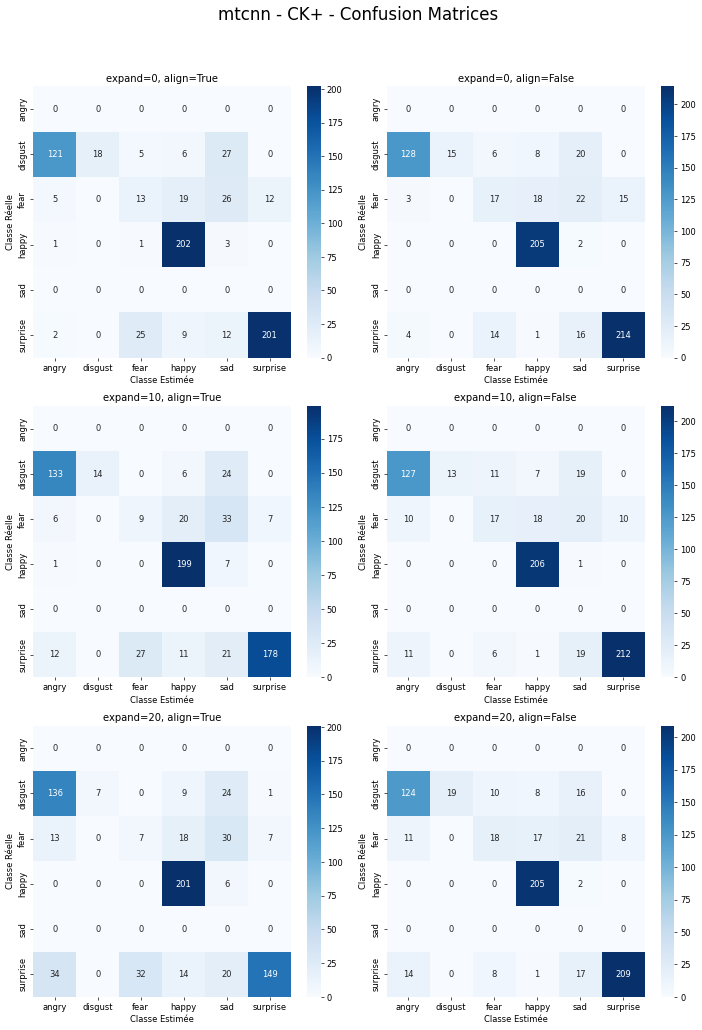


 Résultats enregistrés dans informations_ck_plus/mtcnn\mtcnn_results_summary.txt


In [20]:
run_model("mtcnn", "CK+")

In [ ]:
run_model("mtcnn", "facial_emotion_detection_dataset")


 mtcnn - facial_emotion_detection_dataset

--- Test: expand_percentage=0, align=True ---
Accuracy: 0.4996 | F1: 0.4420 | Avg Confidence: 80.63 | Elapsed Time: 1h 0m 34s

--- Test: expand_percentage=0, align=False ---
Accuracy: 0.4969 | F1: 0.4629 | Avg Confidence: 81.59 | Elapsed Time: 0h 54m 31s

--- Test: expand_percentage=10, align=True ---
Accuracy: 0.4735 | F1: 0.4128 | Avg Confidence: 80.96 | Elapsed Time: 1h 47m 23s

--- Test: expand_percentage=10, align=False ---


MemoryError: Unable to allocate 1.15 MiB for an array with shape (224, 224, 3) and data type float64